## Análisis de la etapa de generación de medios

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU (TODO). Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [5]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [6]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}

In [7]:
def analyze(file_name):
    data = []

    with open(file_name) as log_file: 
        lines = log_file.readlines()
        print(len(lines))
        for line in lines:
            row = {}
            split_line = line.split()
            if "USED" not in split_line or "ELAPSED" not in split_line:
                continue
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            # TODO: add CPU
            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            data.append(row)
            
    df = pd.DataFrame(data)
    df_grouped = df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median']})
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [8]:
def plot_pie(df, function):
    plt.figure(dpi=125, figsize=(6, 6))
    labels = relations[function].copy()
    total = df.loc[function][('time', 'sum')]
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = df.loc[func][('time', 'sum')]
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    labels.append("other")
    sizes.append(rest/total)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    explode.append(0 if rest/total > 0.01 else 0.1)

    plt.title(function)

    patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
    labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

    sort_legend = True
    if sort_legend:
        patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

def plot_analysis(df):
    for func in relations.keys():
        plot_pie(df, func)
    

## N = 8

In [9]:
df = analyze('log_8-aa')

1931


/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


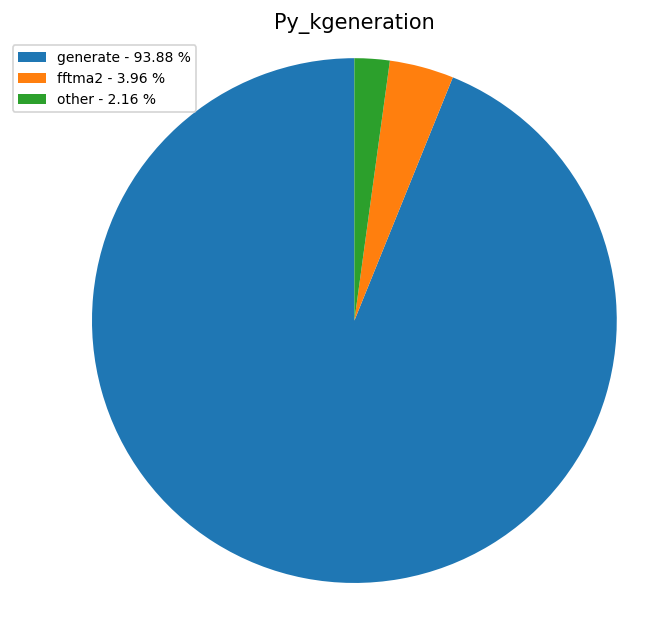

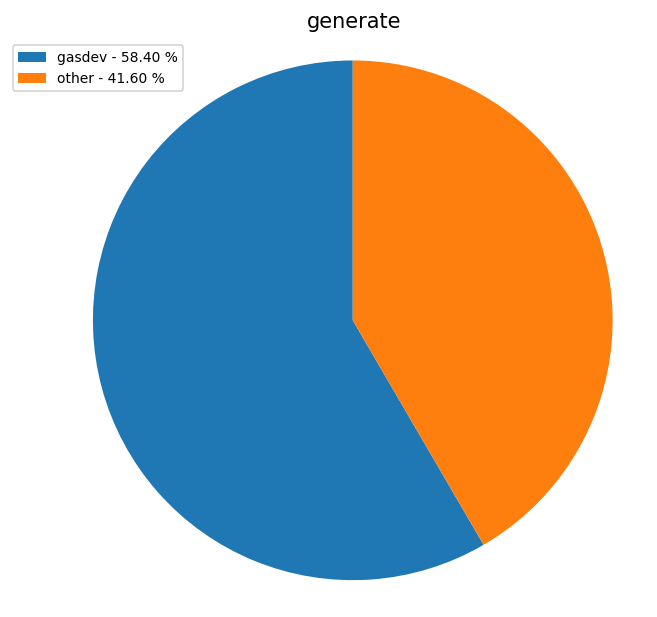

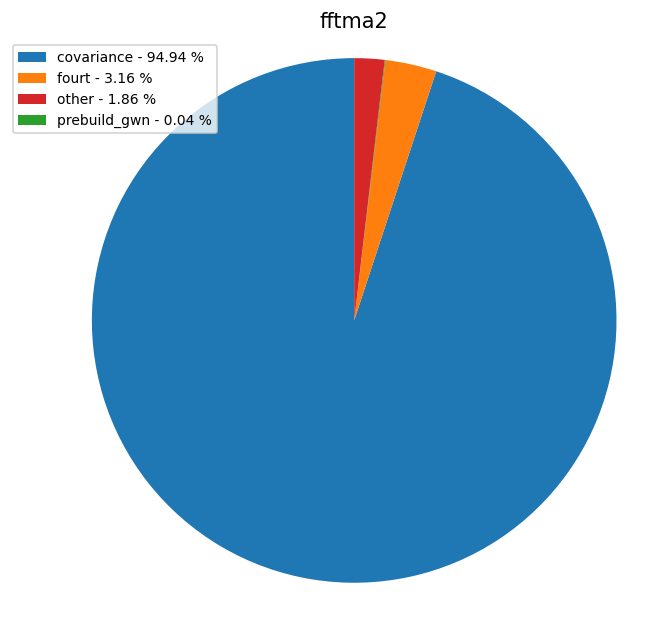

In [10]:
plot_analysis(df)

## N = 16

In [11]:
df = analyze('log_16-aa')

12945


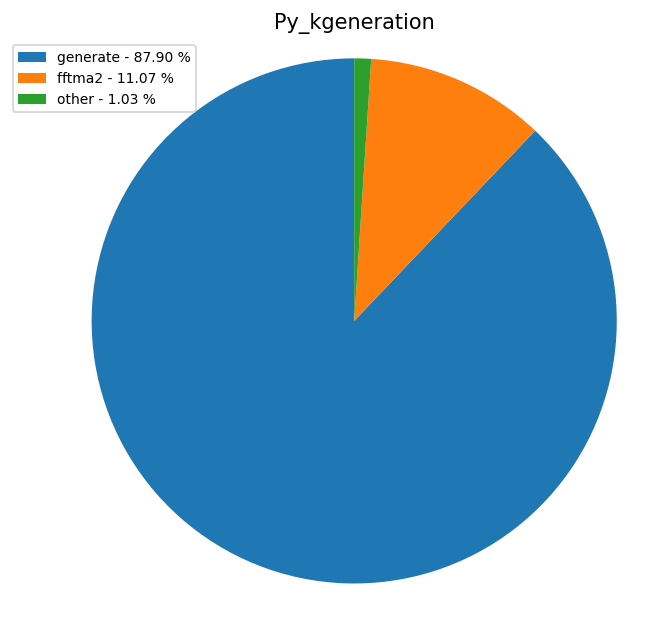

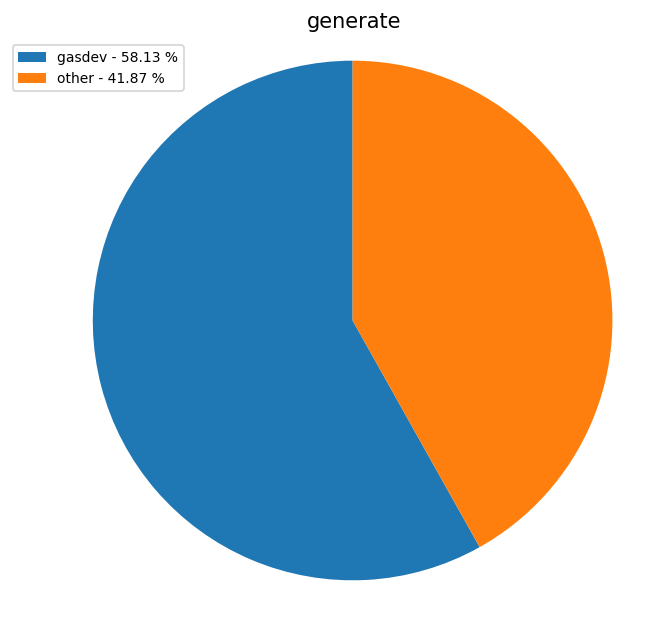

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


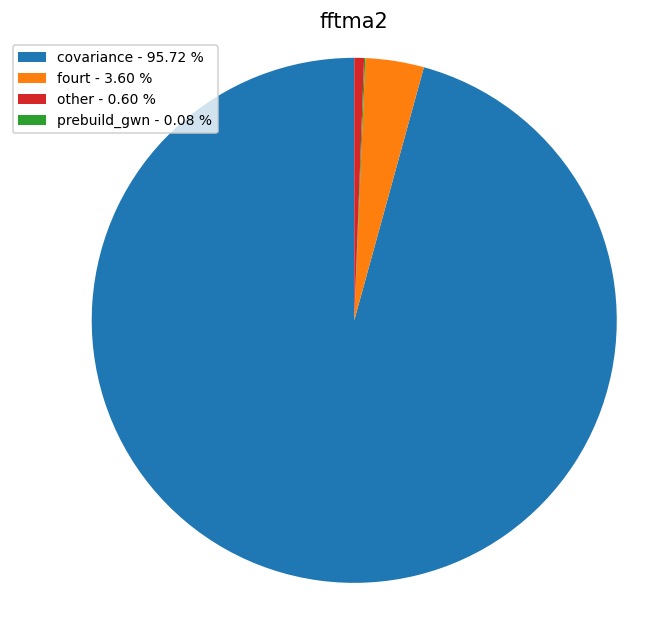

In [12]:
plot_analysis(df)

## N = 32

In [13]:
df = analyze('log_32-aa')

98963


/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


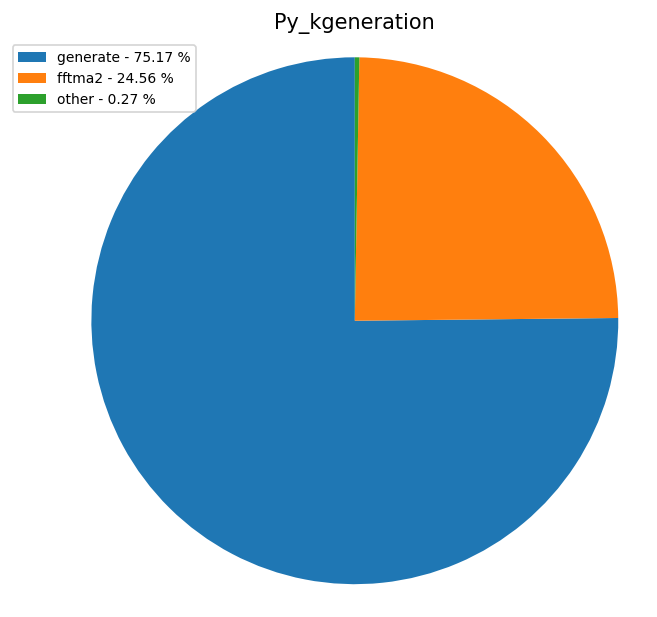

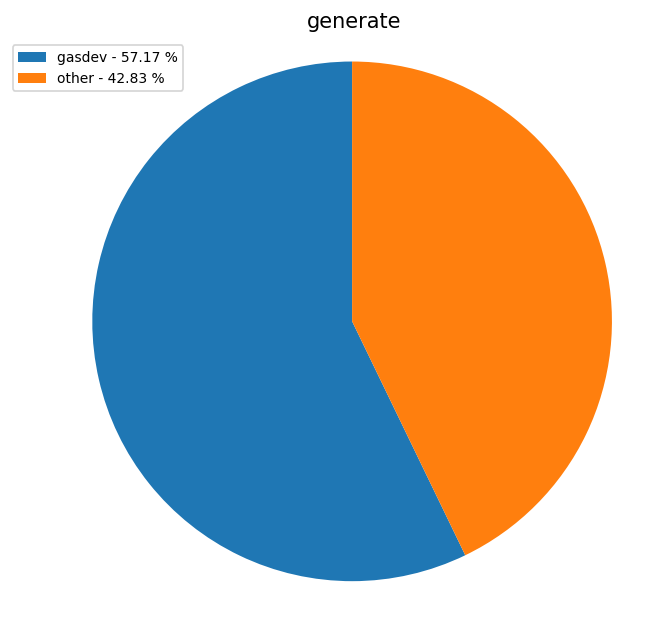

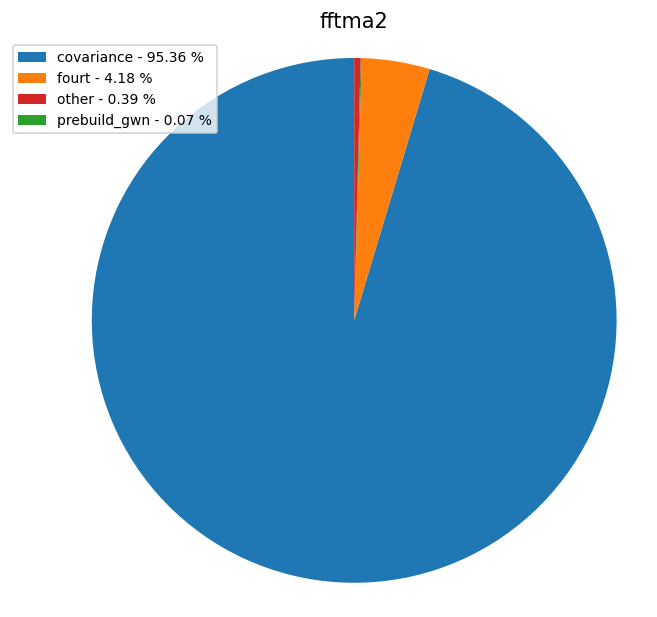

In [14]:
plot_analysis(df)

## N = 64

In [15]:
df = analyze('log_64-aa')

752428


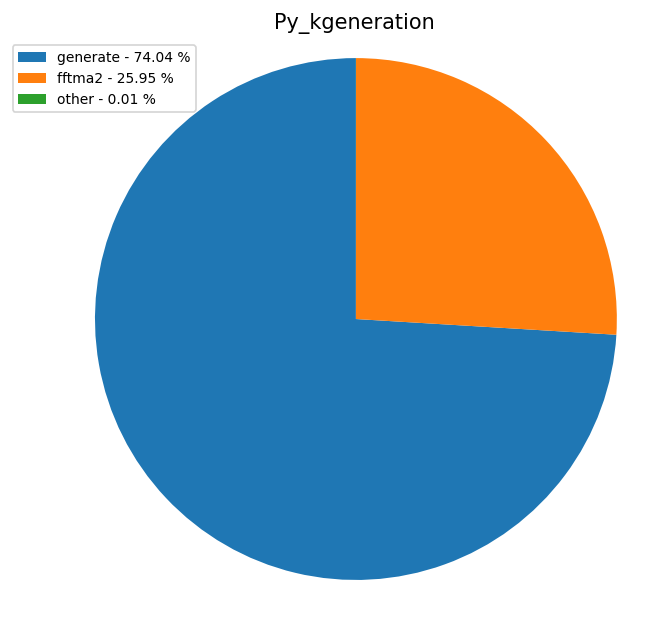

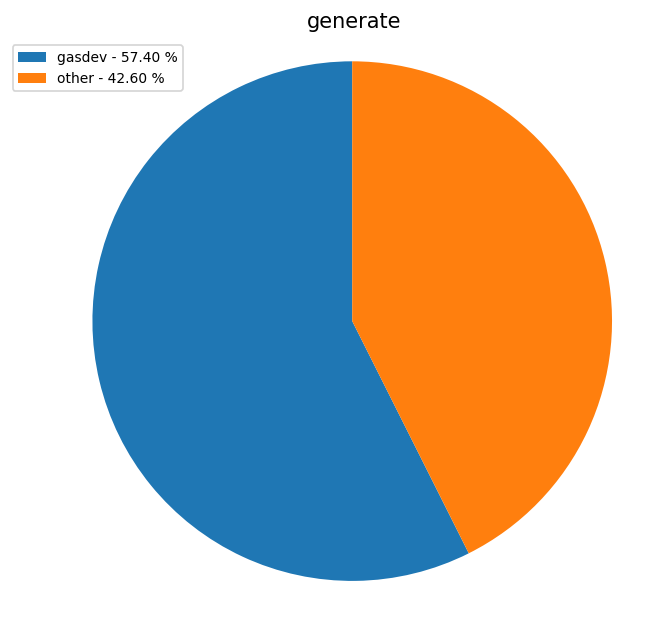

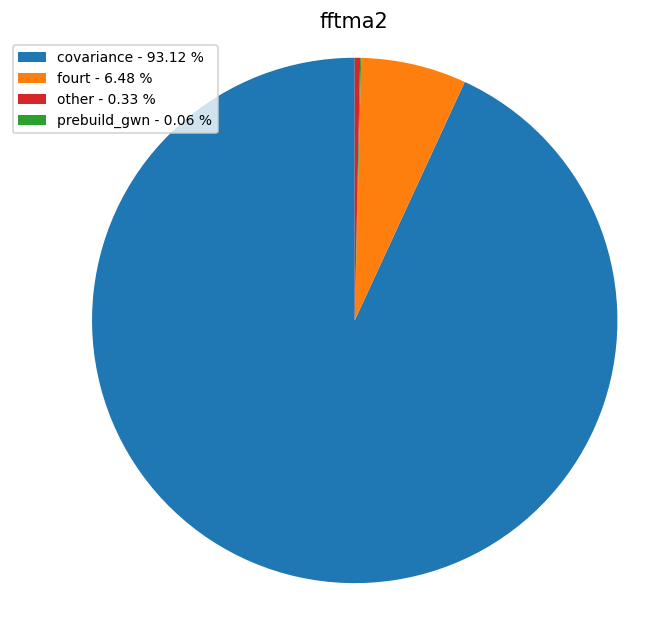

In [16]:
plot_analysis(df)

## N = 128

In [20]:
df = analyze('log_128-aa')

5897863


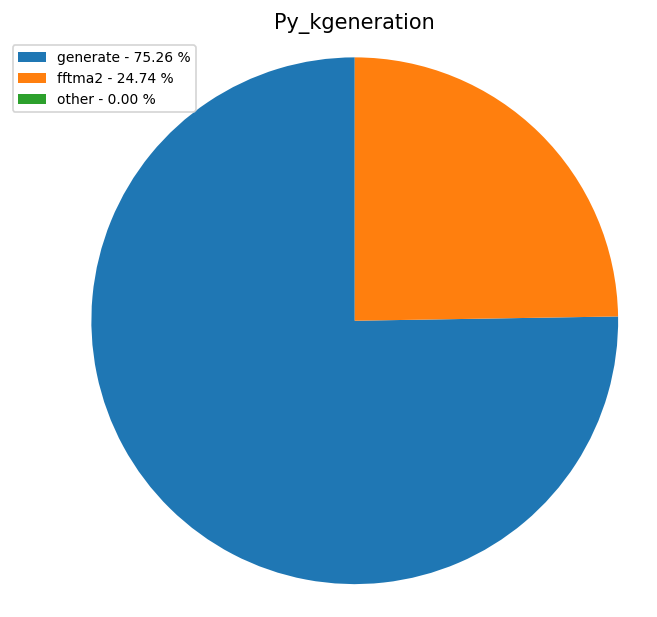

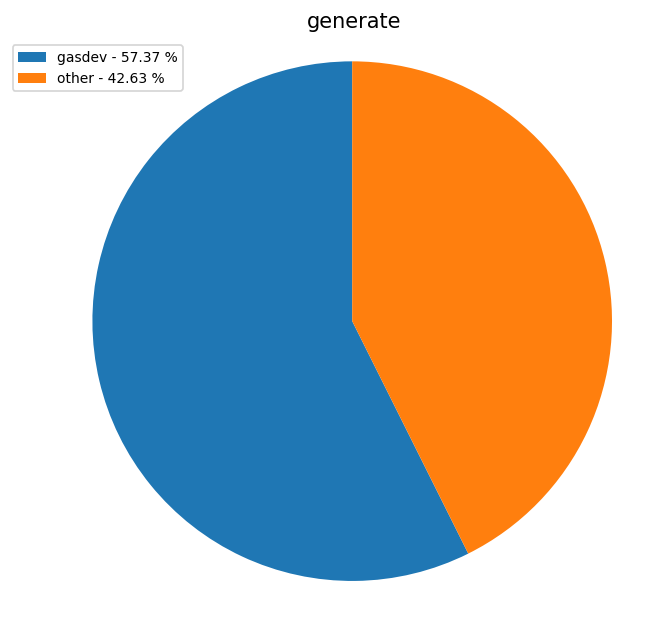

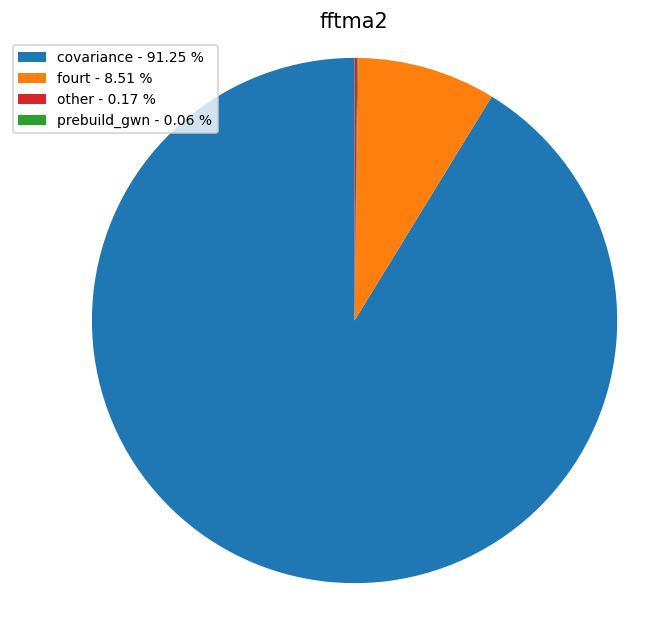

In [21]:
plot_analysis(df)

## N = 256

In [23]:
df = []